# ***Best Sentiment Classifier Transformers***

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

In [ ]:
#Importing data

import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/TFM - ATRIBUS/train.tsv', sep='\t')
df_test=pd.read_csv('/content/drive/MyDrive/TFM - ATRIBUS/test_task2.tsv', sep='\t')

In [ ]:
df.shape, df_test.shape

((5886, 3), (1653, 2))

In [ ]:
df

,id,tweet,label
0,1,El Atlético resignado a perder HASHTAG 😔 http...,sadness
1,2,Leer proporciona una mejor visión del mundo 🤓 ...,joy
2,3,Amo a Arya Stark por encima de todas las cosas...,joy
3,4,Gracias HASHTAG es increíble que una niña logr...,others
4,5,Solo siento que hayamos perdido 24 escaños de ...,sadness
...,...,...,...
5881,5882,Pequeños gestos que puedes hacer por el medio ...,others
5882,5883,¿Sabías que de las dos coronaciones que se cel...,surprise
5883,5884,Mientras reflexionamos sobre lo duro que es es...,anger
5884,5885,La fachada de la catedral de Notre Dame fue “s...,sadness


In [ ]:
df_test

,id,tweet
0,1,El 26 de octubre de 2018 grabé este vídeo dura...
1,2,Se incendió HASHTAG en USER pese a todas las m...
2,3,Me da tristeza saber que fue incendiado y toda...
3,4,Hoy es un día triste en HASHTAG HASHTAG catedr...
4,5,¿Cómo pudo pasar algo así HASHTAG? Una verdade...
...,...,...
1648,1661,Se han dado cuenta que todos esos mentirosos c...
1649,1662,USER USER Pocas cosas son tan imbéciles como l...
1650,1663,Es imposible describir lo que se vive en HASHT...
1651,1664,Dembele de mierda piernas chuecas regalaste do...


In case there is a null or empty value in any column we should have to get rid of it, in order to find it out we will use info() as follows:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5886 entries, 0 to 5885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5886 non-null   int64 
 1   tweet   5886 non-null   object
 2   label   5886 non-null   object
dtypes: int64(1), object(2)
memory usage: 138.1+ KB


In [ ]:
df.isnull().sum()

id        0
tweet     0
label     0
dtype: int64

In [ ]:
df = df.rename({'label ': 'label'}, axis=1) #Rename the column label
df = df[~df.label.str.contains("others")]
df = df[~df.label.str.contains("disgust")]

In [ ]:
label_map = {
    'joy ': 0,
    'sadness ': 1,
    'anger ': 2,
    'surprise ': 3,
    'fear ': 4,
}

df['label'] = df['label'].map(label_map)
df

,id,tweet,label
0,1,El Atlético resignado a perder HASHTAG 😔 http...,1
1,2,Leer proporciona una mejor visión del mundo 🤓 ...,0
2,3,Amo a Arya Stark por encima de todas las cosas...,0
4,5,Solo siento que hayamos perdido 24 escaños de ...,1
5,6,Solo con ver con la intensidad que agitan las ...,0
...,...,...,...
5879,5880,IMPOSIBLE DE VER: Melisandre podría estar ya e...,3
5882,5883,¿Sabías que de las dos coronaciones que se cel...,3
5883,5884,Mientras reflexionamos sobre lo duro que es es...,2
5884,5885,La fachada de la catedral de Notre Dame fue “s...,1


In [ ]:
df.label.value_counts()

0    1270
1     706
2     600
3     241
4      67
Name: label, dtype: int64

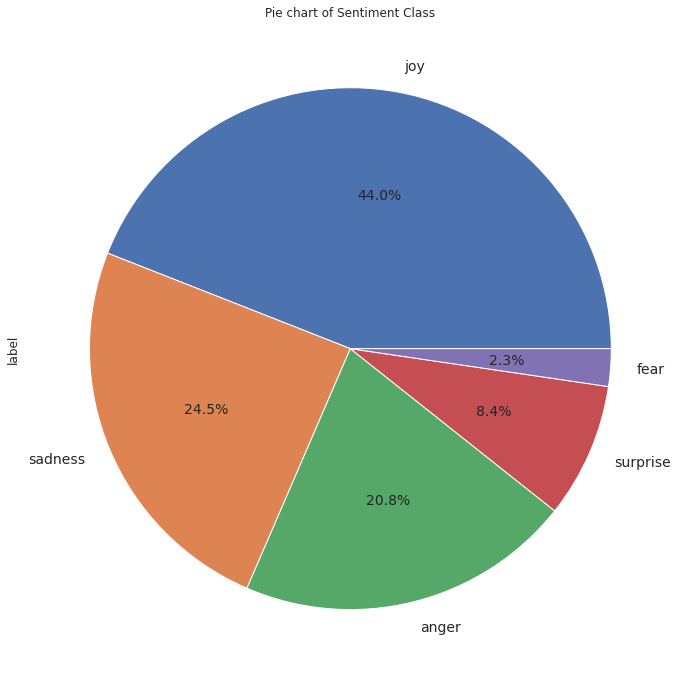

In [ ]:
df2=df.copy(deep=True)
pie1=pd.DataFrame(df2['label'].replace(0,'joy').replace(1,'sadness').replace(2,'anger').replace(3,'surprise').replace(4,'fear').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'label', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

The label is considerably unbalanced, only 'joy' corresponds to more than 50% of instances.  Early we can say the class to be predicted will be sidetracked toward the more frequent classes, this is why we need a text balancing technique just like 'SMOTE' for numerical features.

Time now to find out the number of words in reviews, in order to understand a bit better we will plot histograms for each class

Text(0.5, 0.98, 'Histogram number of words in tweets')

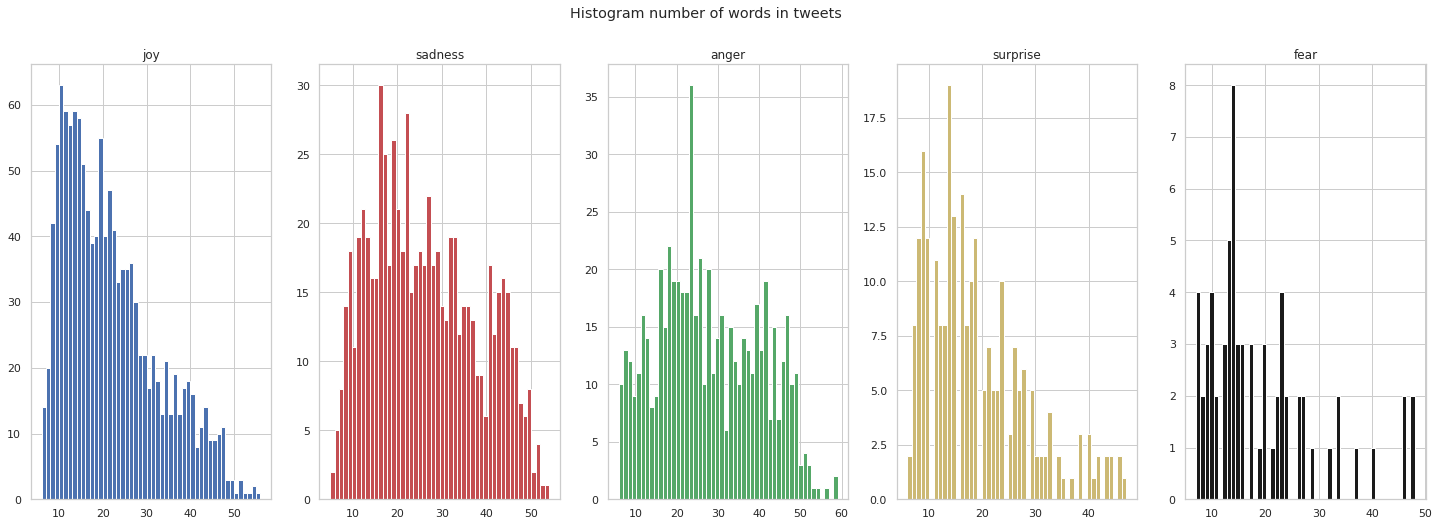

In [ ]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))

ax1.hist(df[df['label'] == 0]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('joy')

ax2.hist(df[df['label'] == 1]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('sadness')

ax3.hist(df[df['label'] == 2]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('anger')

ax4.hist(df[df['label'] == 3]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('surprise')

ax5.hist(df[df['label'] == 4]['tweet'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('fear')

f.suptitle('Histogram number of words in tweets')

# ***Preprocesamiento***

In [ ]:
pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

In [ ]:
def strip_all_entities(text):
    entity_prefixes = ['@','#', '¿', '¡']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: strip_links(x))

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: strip_all_entities(x))

In [ ]:
df['tweet'] = df['tweet'].str.replace(r'HASHTAG', '', regex=True)
df['tweet'] = df['tweet'].str.replace(r'USER', '', regex=True)

In [ ]:
def convert_to_lower(text):
    return text.lower()

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: convert_to_lower(x))

In [ ]:
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_numbers(x))

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_punctuation(x))

In [ ]:
from nltk import word_tokenize #method that will perform text tokenization.

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopword_es = nltk.corpus.stopwords.words('spanish')
stopword = stopword_es

def remove_stopwords(text):
    removed = []
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stopword:
            removed.append(tokens[i])
    return " ".join(removed)

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_stopwords(x))

In [ ]:
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_extra_white_spaces(x))

In [ ]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import emoji

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F" #emoticons
                    u"\U0001F300-\U0001F5FF" #symbols and pictographs
                    u"\U0001F680-\U0001F6FF" #transport and map symbols
                    u"\U0001F1E0-\U0001F1FF" #flags (ios)
                    u"\U00002702-\U000027B0" 
                    u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_emoji(x))

In [ ]:
from cleantext import clean
df['tweet'] = df['tweet'].apply(lambda x: clean(x, no_emoji = True))

# ***Modeling***

In this step we will build, train and compare the following algorithms:

BERT (Bidirectional Encoder Representation from Transformers)
RoBERTa (Robustly Optimized BERT Pre-training Approach)
DistilBERT (Distilled BERT)
XLNet (Generalized Auto-Regressive model)
Each one of the mentioned have its pros and cons, the most preferred and widely used model is the BERT for being the middle term in performance, whereas RoBERTa and .. are known for their better error metrics and DistilBERT for its faster training. We will consider all of these chracteristics and choose the best one for our dataset.

Firstly, we have to install the transformers library offered by HuggingFace so as enable all useful functions when building the four models.



In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

Now we have to gather from the dataset only the two columns useful for training (tweet and label):

In [ ]:
data = df[['tweet', 'label']]

# Set your model output as categorical and save in new label col
data['Sentiment_label'] = pd.Categorical(data['label'])

# Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

Split into train and validation set, as the file contains more than 150 thousand instances we can consider only a small portion of it as validation and still the number is relatively long, because of this we will set the test_size to 10% as follows:

In [ ]:
data_train, data_val = train_test_split(data, test_size = 0.3)

**Bert**

In [ ]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

The model we will use is 'bert_base_uncased' and the max_length chosen is 45 as there are only a very small number of larger sequences.

In [ ]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


As we see below the input layer must consider the max_length of sequences and then this is fed to the bert model, a dropout layer to reduce overfitting (0.1) and finally a dense layer with number of neurons equal to number of classes in our label (5).

In [ ]:
### ------- Build the model ------- ###

# Load the MainLayer
bert = transformer_bert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             45, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

The next cell considers the tokenization of training and validation sentences, setting of label as categorical and finally model training.

In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=8,
    verbose=1)

Epoch 1/8
32/32 [==============================] - 28s 204ms/step - loss: 1.3546 - accuracy: 0.4281 - val_loss: 1.2829 - val_accuracy: 0.4711
Epoch 2/8
32/32 [==============================] - 3s 110ms/step - loss: 1.2241 - accuracy: 0.4936 - val_loss: 1.1468 - val_accuracy: 0.5704
Epoch 3/8
32/32 [==============================] - 3s 109ms/step - loss: 1.0041 - accuracy: 0.6506 - val_loss: 1.0396 - val_accuracy: 0.6201
Epoch 4/8
32/32 [==============================] - 3s 109ms/step - loss: 0.7697 - accuracy: 0.7334 - val_loss: 0.9936 - val_accuracy: 0.6663
Epoch 5/8
32/32 [==============================] - 3s 109ms/step - loss: 0.5699 - accuracy: 0.8112 - val_loss: 1.1044 - val_accuracy: 0.6536
Epoch 6/8
32/32 [==============================] - 3s 108ms/step - loss: 0.4524 - accuracy: 0.8548 - val_loss: 1.0965 - val_accuracy: 0.6536
Epoch 7/8
32/32 [==============================] - 3s 109ms/step - loss: 0.3269 - accuracy: 0.8994 - val_loss: 1.1357 - val_accuracy: 0.6617
Epoch 8/8
32

Evaluate on validation set:

We will compute the error metrics on the validation set in order to have an idea of the model performance

In [ ]:
model_eval = model.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

28/28 [==============================] - 1s 30ms/step - loss: 1.1728 - accuracy: 0.6767


In [ ]:
y_val_predicted = model.predict(
    x={'input_ids': x_val['input_ids']},
)

y_val_predicted corresponds to a numpy array representing the instances and the prediction as one-hot encoded, the actual label is formatted in the same manner, let's them see in detail

In [ ]:
y_val_predicted['Sentiment']

array([[ 0.06210599,  0.9295172 ,  2.516418  , -0.83983344, -2.0053554 ],
       [ 3.671118  , -0.8283005 , -1.5089283 , -0.1619142 , -2.1179872 ],
       [ 3.4493806 , -0.0048007 , -1.5341182 , -0.38781607, -2.4071972 ],
       ...,
       [ 3.7424006 , -1.0986972 , -1.368099  , -0.3099166 , -2.1545935 ],
       [-1.4253047 ,  4.6115136 , -0.34582034, -1.366246  , -0.95753956],
       [-1.3249165 ,  1.2962974 ,  3.387178  , -1.2689594 , -1.0374942 ]],
      dtype=float32)

In order to compute the classification report and confusion matrix we will convert the matrices to one column representing the argmax for each row:

In [ ]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [ ]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       383
           1       0.70      0.64      0.67       220
           2       0.72      0.61      0.66       207
           3       0.20      0.34      0.26        50
           4       0.24      0.83      0.37         6

    accuracy                           0.68       866
   macro avg       0.53      0.64      0.55       866
weighted avg       0.70      0.68      0.69       866



The fact that our dataset is unbalanced in classes makes our prediction absolutely sidetracked towards the most frequent class, in this case (0: 'joy'), because of this the performance of the model is poor when predicting classes 3 or 4, making our model almost unuseful for this task. Below we can see for these 2 classes the number of misclassifications is huge.

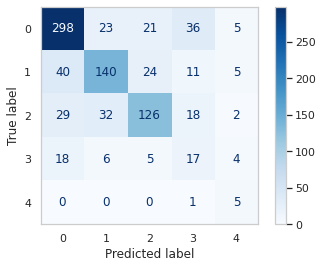

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

Inference:

In this step we will predict the classes corresponding to the test set (out-of-bag) instances, because of the huge dataset we can expect to have almost same performance.

In [ ]:
x_test = tokenizer(
          text=df_test['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [ ]:
label_predicted = model.predict(
    x={'input_ids': x_test['input_ids']},
)

In [ ]:
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]

In [ ]:
label_pred_max[:10]

[0, 1, 1, 1, 1, 0, 1, 1, 1, 0]

# ***RoBERTa***

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig  

In [ ]:
### --------- Setup Roberta ---------- ###

model_name = 'roberta-base'

# Max length of tokens
max_length = 40

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
### ------- Build the model ------- ###

# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model2 = Model(inputs=inputs, outputs=outputs, name='RoBERTa_MultiClass')

# Take a look at the model
model2.summary()

Model: "RoBERTa_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 40)]              0         
                                                                 
 roberta (TFRobertaMainLayer  TFBaseModelOutputWithPoo  124645632
 )                           lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             40, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                

In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model2.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model2.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=8,
    verbose=1)

Epoch 1/8
32/32 [==============================] - 27s 195ms/step - loss: 1.3414 - accuracy: 0.4247 - val_loss: 1.3155 - val_accuracy: 0.4446
Epoch 2/8
32/32 [==============================] - 3s 100ms/step - loss: 1.2699 - accuracy: 0.4787 - val_loss: 1.2231 - val_accuracy: 0.4861
Epoch 3/8
32/32 [==============================] - 3s 100ms/step - loss: 1.0501 - accuracy: 0.6080 - val_loss: 1.0547 - val_accuracy: 0.6097
Epoch 4/8
32/32 [==============================] - 3s 100ms/step - loss: 0.8219 - accuracy: 0.7116 - val_loss: 0.9691 - val_accuracy: 0.6594
Epoch 5/8
32/32 [==============================] - 3s 100ms/step - loss: 0.7015 - accuracy: 0.7413 - val_loss: 0.9633 - val_accuracy: 0.6686
Epoch 6/8
32/32 [==============================] - 3s 100ms/step - loss: 0.5666 - accuracy: 0.8077 - val_loss: 0.9524 - val_accuracy: 0.6975
Epoch 7/8
32/32 [==============================] - 3s 100ms/step - loss: 0.4320 - accuracy: 0.8533 - val_loss: 1.0558 - val_accuracy: 0.7079
Epoch 8/8
32

Evaluate on validation set:

In [ ]:
model_eval = model2.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

28/28 [==============================] - 1s 29ms/step - loss: 1.1007 - accuracy: 0.6790


In [ ]:
y_val_predicted = model2.predict(
    x={'input_ids': x_val['input_ids']},
)

In [ ]:
y_val_predicted['Sentiment']

array([[-0.7246391 ,  2.789117  ,  2.001504  , -2.0872753 , -2.2831347 ],
       [ 3.6647334 , -1.7380717 , -0.9995107 ,  1.3905921 , -2.185984  ],
       [ 4.19842   , -1.3781275 , -1.6998994 ,  0.86762685, -1.9999739 ],
       ...,
       [ 3.0124664 , -0.11403225, -0.20051506,  0.1270103 , -2.632564  ],
       [-1.7204193 ,  4.8704534 , -0.23365043, -1.475207  , -1.450282  ],
       [-0.7800475 ,  0.7236762 ,  3.548383  , -1.5095323 , -2.0631797 ]],
      dtype=float32)

In [ ]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [ ]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       408
           1       0.76      0.62      0.68       247
           2       0.57      0.68      0.62       149
           3       0.22      0.34      0.26        53
           4       0.24      0.56      0.33         9

    accuracy                           0.68       866
   macro avg       0.52      0.59      0.54       866
weighted avg       0.71      0.68      0.69       866



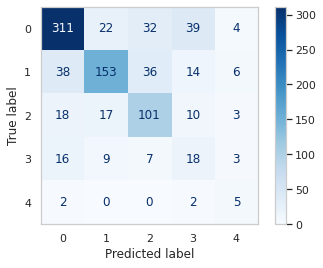

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

Inference

In [ ]:
x_test = tokenizer(
          text=df_test['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [ ]:
label_predicted = model2.predict(
    x={'input_ids': x_test['input_ids']},
)

In [ ]:
label_predicted['Sentiment']

array([[ 3.0753927 ,  0.08918358, -0.37009424, -0.59215945, -2.62266   ],
       [-1.5687135 ,  2.8925524 ,  1.2540561 , -1.3858341 , -1.4366105 ],
       [-0.22721738,  4.0664744 , -0.873913  , -1.2357281 , -1.8686173 ],
       ...,
       [ 3.748582  , -0.26397213, -0.0102345 , -0.67351615, -2.7788053 ],
       [ 1.0203817 , -1.1068838 ,  3.0875542 , -1.0057565 , -2.2814145 ],
       [ 3.1729124 , -1.6036903 ,  0.5029087 ,  0.64157385, -2.5352988 ]],
      dtype=float32)

In [ ]:
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]

In [ ]:
label_pred_max[:10]

[0, 1, 1, 1, 1, 0, 0, 2, 1, 1]

# ***DistilBERT***

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig 

In [ ]:
### --------- Setup DistilBERT ---------- ###

model_name = 'distilbert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = DistilBertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Distilbert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Distilbert model
transformer_distilbert_model = TFDistilBertModel.from_pretrained(model_name, config = config)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


DistilBERT does not consider a pooling layer in the default model which converts the output (None,45,768) to (None,768), this is why we will select the first and third dimension of the 'layer 0' so as to have such output shape required, the next layers are the same as before:

In [ ]:
### ------- Build the model ------- ###

# Load the MainLayer
distilbert = transformer_distilbert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers DistilBERT model as a layer in a Keras model
distilbert_model = distilbert(inputs)[0][:,0,:]
dropout = Dropout(0.1, name='pooled_output')
pooled_output = dropout(distilbert_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model3 = Model(inputs=inputs, outputs=outputs, name='DistilBERT_MultiClass')

# Take a look at the model
model3.summary()

Model: "DistilBERT_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 distilbert (TFDistilBertMai  TFBaseModelOutput(last_h  66362880 
 nLayer)                     idden_state=(None, 45, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 pooled_output (Dropout)     (None, 768)               0         
                                             

In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model3.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model3.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=7,
    verbose=1)

Epoch 1/7
32/32 [==============================] - 14s 108ms/step - loss: 1.3200 - accuracy: 0.4371 - val_loss: 1.3071 - val_accuracy: 0.4573
Epoch 2/7
32/32 [==============================] - 2s 58ms/step - loss: 1.2474 - accuracy: 0.4718 - val_loss: 1.1697 - val_accuracy: 0.5508
Epoch 3/7
32/32 [==============================] - 2s 57ms/step - loss: 0.9648 - accuracy: 0.6566 - val_loss: 0.9702 - val_accuracy: 0.6501
Epoch 4/7
32/32 [==============================] - 2s 58ms/step - loss: 0.7232 - accuracy: 0.7413 - val_loss: 0.9480 - val_accuracy: 0.6594
Epoch 5/7
32/32 [==============================] - 2s 57ms/step - loss: 0.5403 - accuracy: 0.8142 - val_loss: 0.9568 - val_accuracy: 0.6651
Epoch 6/7
32/32 [==============================] - 2s 57ms/step - loss: 0.3939 - accuracy: 0.8677 - val_loss: 1.0165 - val_accuracy: 0.6813
Epoch 7/7
32/32 [==============================] - 2s 58ms/step - loss: 0.2958 - accuracy: 0.9034 - val_loss: 1.0729 - val_accuracy: 0.6709


Evaluate on validation set:

In [ ]:
model_eval = model3.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

28/28 [==============================] - 0s 16ms/step - loss: 1.0729 - accuracy: 0.6709


In [ ]:
y_val_predicted = model3.predict(
    x={'input_ids': x_val['input_ids']},
)

In [ ]:
y_val_predicted['Sentiment']

array([[ 1.0443505 , -0.73355   ,  2.8908355 , -2.2508757 , -2.3169067 ],
       [ 3.091497  , -0.51573795, -0.54510486, -0.14710313, -2.3861287 ],
       [ 0.9808981 , -0.2846927 ,  0.3849291 , -0.5180935 , -2.240549  ],
       ...,
       [ 3.9470234 , -1.9372485 , -0.41527548, -0.27735505, -2.3143032 ],
       [-0.8923189 ,  5.0260177 , -0.7417329 , -1.2275048 , -1.6492627 ],
       [ 1.3420796 ,  0.34315246,  1.503362  , -2.1176865 , -2.3685887 ]],
      dtype=float32)

In [ ]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [ ]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       386
           1       0.69      0.75      0.72       183
           2       0.68      0.53      0.59       224
           3       0.25      0.35      0.29        60
           4       0.38      0.62      0.47        13

    accuracy                           0.67       866
   macro avg       0.55      0.60      0.57       866
weighted avg       0.68      0.67      0.67       866



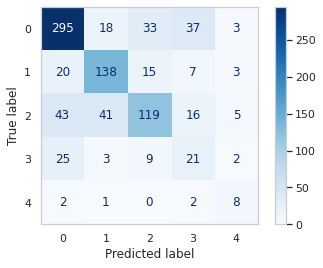

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

Inference:

In [ ]:
x_test = tokenizer(
          text=df_test['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [ ]:
label_predicted = model3.predict(
    x={'input_ids': x_test['input_ids']},
)

In [ ]:
label_predicted['Sentiment']

array([[ 0.5378891 ,  0.69590497,  1.09278   , -1.2472818 , -1.7859262 ],
       [-0.7951327 ,  1.3975502 ,  2.3309512 , -1.9777396 , -1.9187354 ],
       [-0.5829512 ,  2.3606417 ,  1.4099342 , -1.3584719 , -1.9085479 ],
       ...,
       [-0.69215286,  0.9934877 ,  2.7734318 , -2.3767407 , -1.8027506 ],
       [-1.5208125 , -1.596634  ,  4.02332   , -0.92448753, -0.98173845],
       [ 0.48292723, -1.4893041 ,  2.943332  , -0.21267746, -2.4611697 ]],
      dtype=float32)

In [ ]:
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]

In [ ]:
label_pred_max[:10]

[2, 2, 1, 1, 1, 2, 1, 1, 1, 1]